# Introduction

This notebook is a 'quick-start' for the [CGIAR Crop Yield Prediction Challenge](https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge). We'll take a look at the data, fit a quick model and make a submission, with hints at each stage for extra options to investigate.

Let's dive in!

# Setup

You can get the zip files from Zindi or add to your Google drive using the following links:

Test data: https://drive.google.com/file/d/1yTEgzn8JJn0mZmJ7NDUbwAB1WSzwRScB/view?usp=sharing

Training data: 
https://drive.google.com/file/d/1-0UNiBpvfdRq8rgUC3Kb22YPWP_YnoKj/view?usp=sharing

You'll also need the smaller files from Zindi (Train.csv, SampleSubmission.csv and bandnames.txt) which you can just upload using the files tab.

In [1]:
# Copying in the zip files from Google Drive (alternately just upload them)
!cp 'drive/My Drive/image_arrays_train.zip' .
!cp 'drive/My Drive/image_arrays_test.zip' .

In [3]:
# Extract
# !unzip -q data/image_arrays_train.zip
# !unzip -q data/image_arrays_test.zip

In [1]:
# Check the CSV files are present
!ls *.csv # Upload through the files menu

SampleSubmission.csv Train.csv


In [3]:
# Check for bandnames.txt
!ls *.txt

bandnames.txt


# Loading the data

The data isn't a simple table - instead we must read the inputs from individual .npy files. Here we'll load the dataframes, open a file or two and take a look at the format.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

In [5]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


Loading image_arrays_train/CPB2Q2I.npy as an array
Array shape: (360, 41, 41)


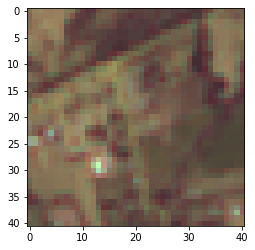

In [7]:
# Look at a sample:
fid = train['Field_ID'].sample().values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

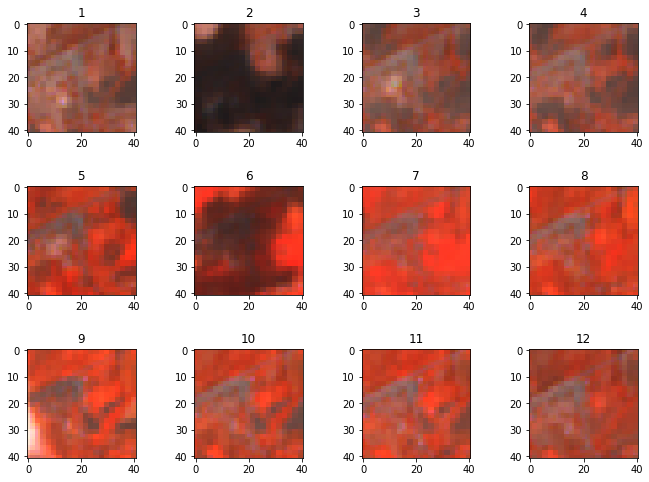

In [8]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
    rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
    rgb = rgb / 4000 # Scaling consistently 
    axs[i].imshow(rgb.clip(0, 1))
    axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

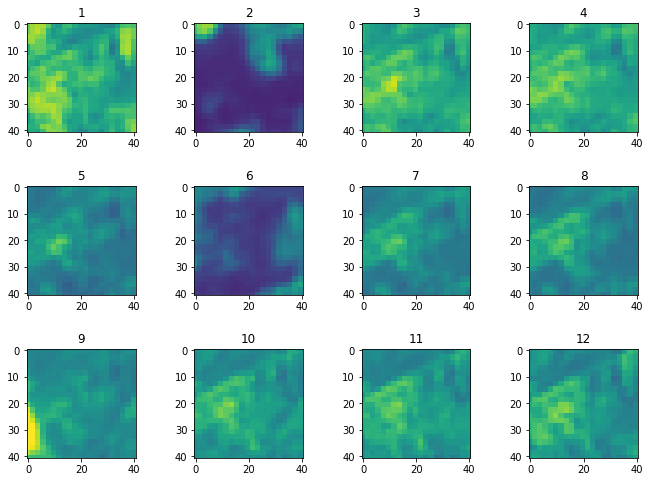

In [9]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
    cloud = arr[i*30 + 11]
    axs[i].imshow(cloud, vmin=0, vmax=4000)
    axs[i].set_title(str(i+1))

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [10]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features:

In [16]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values
train_sampled.head()

,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,Field_ID,Yield
0,744,699,393,790,125,215,MH2O0YH,3.686
1,703,524,323,420,126,215,O9TURWL,5.657
2,2935,2961,3598,4145,135,289,35AFSDD,3.082
3,7289,7389,8025,8057,121,189,PM05EG9,2.707
4,1054,1097,789,1349,194,1214,V7PZBCG,2.679


In [15]:
def process_im(fid, folder='image_arrays_train'):
    fn = f'{folder}/{fid}.npy'
    arr = np.load(fn)
    bands_of_interest = ['S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil']
    values = {}
    for month in range(12):
        bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
        idxs = np.where(np.isin(band_names, bns)) # Index of these bands
        vs = arr[idxs, 20, 20] # Sample the im at the center point
        for bn, v in zip(bns, vs[0]):
            values[bn] = v
    return values

# Example
# process_im('35AFSDD')

# Fitting a model

Now that we have a way to get features from the inputs, we can fit a model and see how it does:

Score: 1.6445717787566667


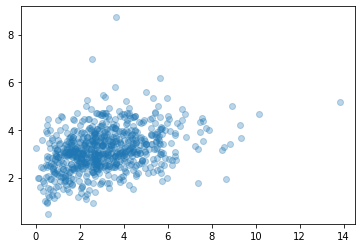

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data
X, y  = train_sampled[train_sampled.columns[:-2]], train_sampled['Yield']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Fit the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Score with RMSE
print('Score:', mean_squared_error(y_test, model.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, model.predict(X_test), alpha=0.3)

# Saving Preds

Once we're happy with how we generate our inputs, we must process the test fields in the same way and save predictions. Here it is, condensed. Note the Field_IDs from the sample submission are used, and the same `process_im` function prepares the inputs, this time looking for .npy files in the 'image_arrays_test' folder. 

In [18]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

# Get model predictions
preds = model.predict(test_sampled)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.629770
1,1WGGS1Q,3.480440
2,EG2KXE2,3.987380
3,HC3GQXF,4.811867
4,7AK6GFK,3.200200


You can submit the Sub.csv file generated here on Zindi. This example scores ~2 (not as good as our score on our local test set, because the fields are more geographically separated). Now let's chat about ways to make this better:

# Improvements


1.   For the example above I chose the 'bands of interest' fairly randomly. A bit of research into which Sentinel 2 bands are used in this kind of task and what the different climate variables are should help make more informed choices there.
2.   We looked at all 12 months. Maize is normally planted just before the March-May rainy season (I think?) and harvested a few months later. Choose which months you'll prioritise to cut down on less useful data
3.   We looked at only the center pixel. Can you use a wider area to get better features? What about finding which pixels are most likely fields and sampling those?
4.   We did no model tuning, so obviously lots of fun to be had there
5.   Low-quality locations are often not fields - leave these out of your training set for better results. There are no low-quality (Quality=1) fields in the test set.
6.   Common measures such as NDVI, EVI etc can be computed by combining different bands. Look up how these vegetative indices are calculated for sentinel 2 and see if you can add those as features.
6.   ... As always, be creative - I'm sure there are lots more improvements to be made

